<a href="https://colab.research.google.com/github/jamesaycheese/MSDS-453/blob/main/MSDS453_Assignment_02_v23_20240315_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://github.com/djp840/MSDS_453_Public/blob/main/images/NorthwesternHeader.png?raw=1">

## **MSDS453 - Research Assignment 02 - Classification and Clustering**

Clustering methods compute a similarity (or closeness) measure, such as Euclidean distance, in order to decide whether two documents are ‘similar’ or not.  

Use the entire class corpus and do sentiment analysis for the positive and negative reviews.

Topic modeling is another way to group ‘similar’ documents into ‘clusters’.

# **1. Modules and Loading Data Set via Google Drive**

In [33]:
import pandas as pd
import os
import numpy as np
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import random
from dataclasses import dataclass

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer

import gensim
from gensim import corpora, similarities
from gensim.models import Word2Vec, LdaMulticore, TfidfModel, CoherenceModel
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import LsiModel,LdaModel

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE, MDS
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.naive_bayes import MultinomialNB

import scipy.cluster.hierarchy

from IPython.display import display, HTML

from typing import List, Callable, Dict

from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

### Mount Google Drive to Colab Environment

<div class="alert alert-block alert-success">
    <b>Directories Required for Research Assignment</b>:<br>
1. Data Directory - Source Class Corpus Data<br>
2. Output Directory - Vocabulary<br>
</div>

#### Uncomment To Map Google Drive

In [34]:
#from google.colab import drive
#drive.mount('/content/gdrive')

&nbsp;

# **2. NLTK Downloads, etc, Data Wrangling Utility Functions, and Loading the Corpus**

In [35]:
# Only run this once, they will be downloaded.
nltk.download('stopwords',quiet=True)
nltk.download('wordnet',quiet=True)
nltk.download('punkt',quiet=True)
nltk.download('omw-1.4',quiet=True)

True

<div class="alert alert-block alert-danger">
<b>Gensim</b> is a Python library for topic modelling, document indexing and similarity retrieval with large corpora. Target audience is the natural language processing (NLP) and information retrieval (IR) community <br><br>
    <b>https://pypi.org/project/gensim/ </b>
</div>

In [36]:
print("Genism Version: ", gensim.__version__)

Genism Version:  4.3.3


<div class="alert alert-block alert-info">
    <b>Suppress warning messages</b></div>

In [37]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

## Data Wrangling Utility Functions

In [38]:
# COMMENTED OUT FUNCTIONS HERE NOT REFERENCED BY OTHER PARTS OF NOTEBOOK

def add_movie_descriptor(data: pd.DataFrame, corpus_df: pd.DataFrame):
    """
    Adds "Movie Description" to the supplied dataframe, in the form {Genre}_{P|N}_{Movie Title}_{DocID}
    """
    review = np.where(corpus_df['Review Type (pos or neg)'] == 'Positive', 'P', 'N')
    data['Descriptor'] = corpus_df['Genre of Movie'] + '_' + corpus_df['Movie Title'] + '_' + review + '_' + corpus_df['Doc_ID'].astype(str)

def get_corpus_df(path):
    data = pd.read_csv(path, encoding="utf-8")
    add_movie_descriptor(data, data)
    sorted_data = data.sort_values(['Descriptor'])
    indexed_data = sorted_data.set_index(['Doc_ID'])
    indexed_data['Doc_ID'] = indexed_data.index
    return indexed_data

@dataclass
class Document:
    doc_id: str
    text: str

# def normalize_document(document: Document) -> Document:
#     text = document.text
#     text = remove_punctuation(text)
#     text = lower_case(text)
#     text = remove_tags(text)
#     text = remove_special_chars_and_digits(text)

#     return Document(document.doc_id, text)

# def normalize_documents(documents: List[Document]) -> List[Document]:
#     """
#     Normalizes text for all given documents.
#     Removes punctuation, converts to lower case, removes tags and special characters.
#     """
#     return [normalize_document(x) for x in documents]

@dataclass
class TokenizedDocument:
    doc_id: str
    tokens: List[str]

# def tokenize_document(document: Document) -> TokenizedDocument:
#     tokens = nltk.word_tokenize(document.text)
#     return TokenizedDocument(document.doc_id, tokens)

# def tokenize_documents(documents: List[Document]) -> List[TokenizedDocument]:
#     return [tokenize_document(x) for x in documents]

# def lemmatize(documents: List[TokenizedDocument]) -> List[TokenizedDocument]:
#     result = []
#     lemmatizer = WordNetLemmatizer()
#     for document in documents:
#         output_tokens = [lemmatizer.lemmatize(w) for w in document.tokens]
#         result.append(TokenizedDocument(document.doc_id, output_tokens))
#
#     return result

# def stem(documents: List[TokenizedDocument]) -> List[TokenizedDocument]:
#     result = []
#     stemmer = PorterStemmer()
#     for document in documents:
#         output_tokens = [stemmer.stem(w) for w in document.tokens]
#         result.append(TokenizedDocument(document.doc_id, output_tokens))
#
#     return result

# def remove_stop_words(documents: List[TokenizedDocument]) -> List[TokenizedDocument]:
#     result = []
#
#     stop_words = set(nltk.corpus.stopwords.words('english'))
#     for document in documents:
#         filtered_tokens = [w for w in document.tokens if not w in stop_words]
#         result.append(TokenizedDocument(document.doc_id, filtered_tokens))
#
#     return result

# def add_flags(data: pd.DataFrame, casino_royale_doc_ids: List[int], action_doc_ids: List[int]):
#     data['is_casino_royale'] = data.index.isin(casino_royale_doc_ids)
#     data['is_action'] = data.index.isin(action_doc_ids)

# def get_all_tokens(documents: List[TokenizedDocument]) -> List[str]:
#     tokens = {y for x in documents for y in x.tokens}
#     return sorted(list(tokens))

def clean_doc(doc):
    #split document into individual words
    tokens=doc.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 4]
    #lowercase all words
    tokens = [word.lower() for word in tokens]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # word stemming
    # ps=PorterStemmer()
    # tokens=[ps.stem(word) for word in tokens]
    return tokens

# def final_processed_text_disabled(doc):
#     #this is a function to join the processed text back
#     ' '.join(doc)
#     return doc

def tfidf(corpus, titles, ngram_range = (1,1)):
    #this is a function to created the tfidf matrix
    Tfidf=TfidfVectorizer(ngram_range=(1,1))

    #fit the vectorizer using final processed documents.  The vectorizer requires the
    #stiched back together document.

    TFIDF_matrix=Tfidf.fit_transform(corpus)

    #creating datafram from TFIDF Matrix

    # https://stackoverflow.com/questions/70215049/attributeerror-tfidfvectorizer-object-has-no-attribute-get-feature-names-out
    #words = Tfidf.get_feature_names() # For sklearn <= 0.24.x
    #matrix=pd.DataFrame(TFIDF_matrix.toarray(), columns=Tfidf.get_feature_names(), index=titles)

    words = Tfidf.get_feature_names_out() # For sklearn >= 1.0.x
    matrix=pd.DataFrame(TFIDF_matrix.toarray(), columns=Tfidf.get_feature_names_out(), index=titles)
    return matrix #,words

def One_Hot(variable):
    #this is a function to one hot encode the classes
    LE=LabelEncoder()
    LE.fit(variable)
    Label1=LE.transform(variable)
    OHE=OneHotEncoder()
    labels=OHE.fit_transform(Label1.reshape(-1,1)).toarray()
    return labels

&nbsp;

# **3. Functions Latent Semantic Analysis, Latent Dirichlet Allocation, Word2Vec Matrix**
1. Latent Semantic Analysis
2. Latent Dirichlet Allocation
3. Word2Vec Matrix creation

In [39]:
def create_gensim_lsa_model(doc_clean,number_of_topics,words):

    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LSA model
    # train model
    lsamodel = LsiModel(doc_term_matrix
                        ,num_topics=number_of_topics
                        ,id2word = dictionary
                        ,power_iters=100)
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    index = similarities.MatrixSimilarity(lsamodel[doc_term_matrix])

    return lsamodel,dictionary,index

def lsa(tfidf_matrix, terms, n_components = 10):
    #this is a function to execute lsa.  inputs to the function include the tfidf matrix and
    #the desired number of components.

    LSA = TruncatedSVD(n_components=10)
    LSA.fit(tfidf_matrix)

    for i, comp in enumerate(LSA.components_):
        terms_comp = zip(terms, comp)
        sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
        print("Topic "+str(i)+": ")
        for t in sorted_terms:
            print(t[0])

def create_gensim_lda_model(doc_clean,number_of_topics,words):

    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    ldamodel = LdaModel(doc_term_matrix
                        ,num_topics=number_of_topics
                        ,id2word = dictionary
                        ,alpha='auto'
                        ,eta='auto'
                        ,iterations=100
                        ,random_state=23
                        ,passes=20)
    # train model
    print(ldamodel.print_topics(num_topics=number_of_topics, num_words=words))
    index = similarities.MatrixSimilarity(ldamodel[doc_term_matrix])
    return ldamodel,dictionary,index,doc_term_matrix

def lda(tfidf_matrix, terms, topics = 3, num_words = 10):
    #this is a function to perform lda on the tfidf matrix.  function varibales include:
    #tfidf matrix, desired number of topic, and number of words per topic.

    topics = 3
    num_words = 10
    lda = LatentDirichletAllocation(n_components=topics).fit(tfidf_matrix)

    topic_dict = {}
    for topic_num, topic in enumerate(lda.components_):
        topic_dict[topic_num] = " ".join([terms[i]for i in topic.argsort()[:-num_words - 1:-1]])

    print(topic_dict)

def word2vec(processed_text, size = 100):
    #This is a function to generate the word2vec matrix. Input parameters include the
    #tokenized text and matrix size

    #word to vec
    model_w2v = Word2Vec(processed_text, vector_size=100, window=5, min_count=1, workers=4)

    #join all processed DSI words into single list
    processed_text_w2v=[]
    for i in processed_text:
        for k in i:
            processed_text_w2v.append(k)

    #obtian all the unique words from DSI
    w2v_words=list(set(processed_text_w2v))

    #can also use the get_feature_names() from TFIDF to get the list of words
    #w2v_words=Tfidf.get_feature_names()

    #empty dictionary to store words with vectors
    w2v_vectors={}

    #for loop to obtain weights for each word
    for i in w2v_words:
        temp_vec=model_w2v.wv[i]
        w2v_vectors[i]=temp_vec

    #create a final dataframe to view word vectors
    w2v_df=pd.DataFrame(w2v_vectors).transpose()
    print(w2v_df)
    return w2v_df

## This code below is Experimental#1 and Barry wants your feedback if this works or not

In [40]:
## Experimental#1 code here will show you the movie titles for the topics
## Uncomment all the code in this cell and it will override the above functions
## Also switch ot the modified Experiment#1 code lines elsewhere to add the "titles" parameter
## or you can ignore the commented lines for Experiment#1 code and continue your assignment.

# def create_gensim_lda_model(doc_clean,number_of_topics,words, titles):
#
#     dictionary = corpora.Dictionary(doc_clean)
#     doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
#     ldamodel = LdaModel(doc_term_matrix ,num_topics=number_of_topics,id2word = dictionary,alpha='auto',
#                                           eta='auto',iterations=100,random_state=23,passes=20)
#     print(ldamodel.print_topics(num_topics=number_of_topics, num_words=words))
#     index = similarities.MatrixSimilarity(ldamodel[doc_term_matrix])
#
#     # THIS CODE BELOW IS EXPERIMENTAL#1 AND BARRY WANTS YOUR FEEDBACK IF THIS WORKS OR NOT
#
#     # Method 1: Shows top 5 titles related to a topic; adjust the number accordingly.
#     for topic in ldamodel.print_topics(num_topics=number_of_topics, num_words=words):
#         topic_number = topic[0]
#         sims = index[ldamodel[doc_term_matrix[topic_number]]]
#         most_similar_titles = [titles[i[0]] for i in sorted(enumerate(sims), key=lambda item: -item[1])[:5]]
#         print('Most similar titles for topic #{}: {}'.format(topic_number, most_similar_titles))
#
#     # Method 2: Shows all titles sorted on most similar for each topic.
#     # Note you get all titles for all topics!
#
#     for document in doc_clean:
#         doc_bow = dictionary.doc2bow(document)
#         sims = index[ldamodel[doc_bow]]
#         most_similar_topic = sorted(enumerate(sims), key=lambda item: -item[1])[0][0]
#         #VERBOSE DEBUGGING: print('Document belongs to topic #{}'.format(most_similar_topic))
#
#     topic_titles = {}
#     for topic_number, topic in enumerate(ldamodel.print_topics(num_topics=number_of_topics, num_words=words)):
#         sims = index[ldamodel[doc_term_matrix[topic_number]]]
#         titles_for_topic = [titles[i[0]] for i in sorted(enumerate(sims), key=lambda item: -item[1])]
#         topic_titles[topic_number] = titles_for_topic
#         print('Titles for topic #{}: {}'.format(topic_number, titles_for_topic))
#
#     return ldamodel,dictionary,index,doc_term_matrix

###########

# def create_gensim_lsa_model(doc_clean, number_of_topics, words, titles):
#
#     dictionary = corpora.Dictionary(doc_clean)
#     doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
#
#     # generate LSA model
#     lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word=dictionary, power_iters=100)
#
#     print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
#     index = similarities.MatrixSimilarity(lsamodel[doc_term_matrix])
#
#     # THIS CODE BELOW IS EXPERIMENTAL AND BARRY WANTS YOUR FEEDBACK IF THIS WORKS OR NOT
#
#     # Method 1: Shows top 5 titles related to a topic; adjust the number accordingly.
#     for topic in lsamodel.print_topics(num_topics=number_of_topics, num_words=words):
#         topic_number = topic[0]
#         sims = index[lsamodel[doc_term_matrix[topic_number]]]
#         most_similar_titles = [titles[i[0]] for i in sorted(enumerate(sims), key=lambda item: -item[1])[:5]]
#         print('Most similar titles for topic #{}: {}'.format(topic_number, most_similar_titles))
#
#     # Method 2: Shows all titles sorted on most similar for each topic.
#     # Note you get all titles for all topics!
#
#     for document in doc_clean:
#         doc_bow = dictionary.doc2bow(document)
#         sims = index[lsamodel[doc_bow]]
#         most_similar_topic = sorted(enumerate(sims), key=lambda item: -item[1])[0][0]
#         #VERBOSE DEBUGGING: print('Document belongs to topic #{}'.format(most_similar_topic))
#
#     topic_titles = {}
#     for topic_number, topic in enumerate(lsamodel.print_topics(num_topics=number_of_topics, num_words=words)):
#         sims = index[lsamodel[doc_term_matrix[topic_number]]]
#         titles_for_topic = [titles[i[0]] for i in sorted(enumerate(sims), key=lambda item: -item[1])]
#         topic_titles[topic_number] = titles_for_topic
#         print('Titles for topic #{}: {}'.format(topic_number, titles_for_topic))
#
#     return lsamodel, dictionary, index
#
############
##
## When you call create_gensim_lda_model(...) later on, you have to add titles to the call. Eg:
##
## model2,dictionary2,index2,doctermmatrix2=create_gensim_lda_model(processed_text,number_of_topics,words,titles)
##
## Similarly for LSA...

# **4. Modeling Functions: KMeans, SVM, Logistic, Naive Bayes, Randomforest, BERTopic**

In [41]:
def k_means(titles, tfidf_matrix, k=4):

    #this is a function to generate the k-means output using the tfidf matrix.  Inputs
    #to the function include: titles of text, processed text, and desired k value.
    #Returns dataframe indicating cluster number per document

    km = KMeans(n_clusters=k, random_state =89)
    km.fit(tfidf_matrix)
    clusters = km.labels_.tolist()

    Dictionary={'Doc Name':titles, 'Cluster':clusters,  'Text': final_processed_text}
    frame=pd.DataFrame(Dictionary, columns=['Cluster', 'Doc Name','Text'])
    #dictionary to store clusters and respective titles
    cluster_title={}

    #note doc2vec clusters will not have individual words due to the vector representation
    #is based on the entire document not indvidual words. As a result, there won't be individual
    #word outputs from each cluster.
    for i in range(k):
        temp=frame[frame['Cluster']==i]
        temp_title_list=[]
        for title in temp['Doc Name']:
            temp_title_list.append(title)
        cluster_title[i]=temp_title_list

    # How to see the results of the k-means clustering
    #print ("cluster_title", cluster_title)
    #print ("clusters", clusters)
    #print ("frame", frame)
    return cluster_title,clusters,frame

def bert_pretrained(texts):
    # Initialize the classifier
    classifier = pipeline("sentiment-analysis")

    # Perform sentiment analysis
    results = []
    for text in texts:
        # Since the classifier can only handle a certain amount of text,
        # you might need to truncate or split the text accordingly.
        result = classifier(text[:512])  # Adjust if necessary
        results.append(result)

    return results

def classifiers(x, y, model_type, cv = 3):

    #this function is to fit 3 different model scenarios.  Support vector machines, logistic regressions, naive bayes.
    #svm = Support vector machin
    #logistic = Logistic regression
    #naive_bayes = Naive Bayes Multinomial

    #can define cv value for cross validation.

    #function returns the train test split scores of each model.

    if model_type == 'svm':
        print("svm")
        model = SVC()

    elif model_type == 'logistic':
        print("logistic")
        model = LogisticRegression()

    elif model_type == 'naive_bayes':
        print("naive_bayes")
        model = MultinomialNB()

    elif model_type == 'randomforest':
        print("randomforest")
        model = RandomForestClassifier()

    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.10, random_state=23)
    model.fit(X_train, y_train)

    predictions = model.predict(X_test)
    accy = accuracy_score(y_test, predictions)
    return accy

## Visualization Utility Functions

In [42]:
def plot_lsa(number_of_topics, words):

    # BARRYC experimental#1
    #model,dictionary,index=create_gensim_lsa_model(processed_text,number_of_topics,words,titles)
    model,dictionary,index=create_gensim_lsa_model(processed_text,number_of_topics,words)

    for doc in processed_text:
        vec_bow = dictionary.doc2bow(doc)
        vec_lsi = model[vec_bow]  # convert the query to LSI space
        sims = index[vec_lsi] # perform a similarity query against the corpus

    fig, ax = plt.subplots(figsize=(30, 10))
    cax = ax.matshow(index, interpolation='nearest')
    ax.grid(True)
    plt.xticks(range(len(processed_text)), titles, rotation=90);
    plt.yticks(range(len(processed_text)), titles);
    fig.colorbar(cax)
    plt.show()
    return model

def plot_tfidf_matrix(cluster_title,clusters,TFIDF_matrix):
    # convert two components as we're plotting points in a two-dimensional plane
    # "precomputed" because we provide a distance matrix
    # we will also specify `random_state` so the plot is reproducible.

    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
    dist = 1 - cosine_similarity(TFIDF_matrix)
    pos = mds.fit_transform(dist)  # shape (n_components, n_samples)
    xs, ys = pos[:, 0], pos[:, 1]


    #set up colors per clusters using a dict.  number of colors must correspond to K
    cluster_colors = {0: 'black', 1: 'grey', 2: 'blue', 3: 'rosybrown', 4: 'firebrick',
                      5:'red', 6:'darksalmon', 7:'sienna'}

    #set up cluster names using a dict.
    cluster_dict=cluster_title

    #create data frame that has the result of the MDS plus the cluster numbers and titles
    df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=range(0,len(clusters))))

    #group by cluster
    groups = df.groupby('label')

    fig, ax = plt.subplots(figsize=(20,20)) # set size
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

    #iterate through groups to layer the plot
    #note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
    for name, group in groups:

        r = random.random()
        b = random.random()
        g = random.random()
        color = (r, g, b)

        ax.plot(group.x, group.y, marker='o', linestyle='', ms=12,
                label=cluster_dict[name], color=color,
                mec='none')
        ax.set_aspect('auto')
        ax.tick_params(\
            axis= 'x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom='off',      # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            labelbottom='on')
        ax.tick_params(\
            axis= 'y',         # changes apply to the y-axis
            which='both',      # both major and minor ticks are affected
            left='off',      # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            labelleft='on')

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 30})      #show legend with only 1 point

## Loading the Class Corpus

In [43]:
CORPUS_PATH=\
'https://raw.githubusercontent.com/barrycforever/MSDS_453_NLP/main/MSDS453_ClassCorpus/MSDS453_ClassCorpus_Final_Sec56_v1_20241003.csv'
data = get_corpus_df(CORPUS_PATH)

In [44]:
#adding two columns to the dataframe to store the processed text and tokenized text
data['processed_text'] = data['Text'].apply(lambda x: clean_doc(x))

#creating final processed text variables for matrix creation
final_processed_text = [' '.join(x) for x in data['processed_text'].tolist()]
titles = data['DSI_Title'].tolist()
processed_text = data['processed_text'].tolist()

1. Dataframe = corpus_df
2. List = documents (Document ID, Text)

&nbsp;

# **5. Exploratory Data Analysis**

In [45]:
CORPUS_PATH=\
'https://raw.githubusercontent.com/barrycforever/MSDS_453_NLP/main/MSDS453_ClassCorpus/MSDS453_ClassCorpus_Final_Sec56_v1_20241003.csv'
corpus_df = get_corpus_df(CORPUS_PATH)
documents = [Document(x, y) for x, y in zip(corpus_df.Doc_ID, corpus_df.Text)]

In [46]:
corpus_df.shape

(200, 9)

In [47]:
corpus_df.head().T

Doc_ID                                                                  166  \
DSI_Title                             PLW_Doc6_Kingsman__The_Secret_Service   
Submission File Name                  PLW_Doc6_Kingsman__The_Secret_Service   
Student Name                                                            PLW   
Genre of Movie                                                       Action   
Review Type (pos or neg)                                           Negative   
Movie Title                                    Kingsman__The_Secret_Service   
Text                      One complaint that has always dogged the James...   
Descriptor                        Action_Kingsman__The_Secret_Service_N_166   
Doc_ID                                                                  166   

Doc_ID                                                                  167  \
DSI_Title                             PLW_Doc7_Kingsman__The_Secret_Service   
Submission File Name                  PLW_Doc7_Kingsman__The_Secret_Service   
Student Name                                                            PLW   
Genre of Movie                                                       Action   
Review Type (pos or neg)                                           Negative   
Movie Title                                    Kingsman__The_Secret_Service   
Text                      The main reason Kingsman: The Secret Service l...   
Descriptor                        Action_Kingsman__The_Secret_Service_N_167   
Doc_ID                                                                  167   

Doc_ID                                                                  168  \
DSI_Title                             PLW_Doc8_Kingsman__The_Secret_Service   
Submission File Name                  PLW_Doc8_Kingsman__The_Secret_Service   
Student Name                                                            PLW   
Genre of Movie                                                       Action   
Review Type (pos or neg)                                           Negative   
Movie Title                                    Kingsman__The_Secret_Service   
Text                      "Kingsman: The Secret Service" makes up its ow...   
Descriptor                        Action_Kingsman__The_Secret_Service_N_168   
Doc_ID                                                                  168   

Doc_ID                                                                  169  \
DSI_Title                             PLW_Doc9_Kingsman__The_Secret_Service   
Submission File Name                  PLW_Doc9_Kingsman__The_Secret_Service   
Student Name                                                            PLW   
Genre of Movie                                                       Action   
Review Type (pos or neg)                                           Negative   
Movie Title                                    Kingsman__The_Secret_Service   
Text                      Silly, sadistic and finally a little galling, ...   
Descriptor                        Action_Kingsman__The_Secret_Service_N_169   
Doc_ID                                                                  169   

Doc_ID                                                                  170  
DSI_Title                            PLW_Doc10_Kingsman__The_Secret_Service  
Submission File Name                 PLW_Doc10_Kingsman__The_Secret_Service  
Student Name                                                            PLW  
Genre of Movie                                                       Action  
Review Type (pos or neg)                                           Negative  
Movie Title                                    Kingsman__The_Secret_Service  
Text                      "The Spy Who Amused Me," James Bond, has abdic...  
Descriptor                        Action_Kingsman__The_Secret_Service_N_170  
Doc_ID                                                                  170

In [48]:
print(corpus_df.info());

<class 'pandas.core.frame.DataFrame'>
Index: 200 entries, 166 to 269
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   DSI_Title                 200 non-null    object
 1   Submission File Name      200 non-null    object
 2   Student Name              200 non-null    object
 3   Genre of Movie            200 non-null    object
 4   Review Type (pos or neg)  200 non-null    object
 5   Movie Title               200 non-null    object
 6   Text                      200 non-null    object
 7   Descriptor                200 non-null    object
 8   Doc_ID                    200 non-null    int64 
dtypes: int64(1), object(8)
memory usage: 15.6+ KB
None


In [49]:
print(corpus_df['Movie Title'].unique())

['Kingsman__The_Secret_Service' 'No_Time_to_Die' 'Taken'
 'The_Batman(2022)' 'Top_Gun' 'Barbie' 'Dirty_Grandpa' 'Lost_City'
 'Mean_Girls' 'Scott_Pilgrim_vs._the_World' 'Drag_Me_To_Hell' 'Fresh'
 'It_Chapter_Two' 'The_Conjuring_2' 'The_Others' 'Equilibirum' 'Inception'
 'Minority_Report' 'Oblivion' 'Pitch_Black']


Exploring different numbers of...


> LSA: **2**, **6**, **20** concepts and **10** words<br>
> LDA: **2**, **6**, **20** topics and **10** words<br>

1.   *Model Complexity*
2.   *Model Interpretability*
3.   *Evaluation of Coherence*
4.   *Avoid Overfitting*
5.   *Practical Implications*
6.   *Computational Implications*


## Latent Semantic Analysis - Research Number of Topics and Number of Words

### Plotting 2 concepts and 10 words

[(0, '0.531*"movie" + 0.149*"films" + 0.148*"movies" + 0.142*"character" + 0.139*"story" + 0.128*"characters" + 0.127*"horror" + 0.122*"action" + 0.120*"first" + 0.115*"barbie"'), (1, '0.806*"barbie" + 0.161*"world" + -0.144*"movie" + 0.140*"gerwig" + 0.132*"gosling" + 0.124*"robbie" + 0.120*"barbies" + 0.120*"margot" + -0.111*"batman" + 0.090*"girls"')]


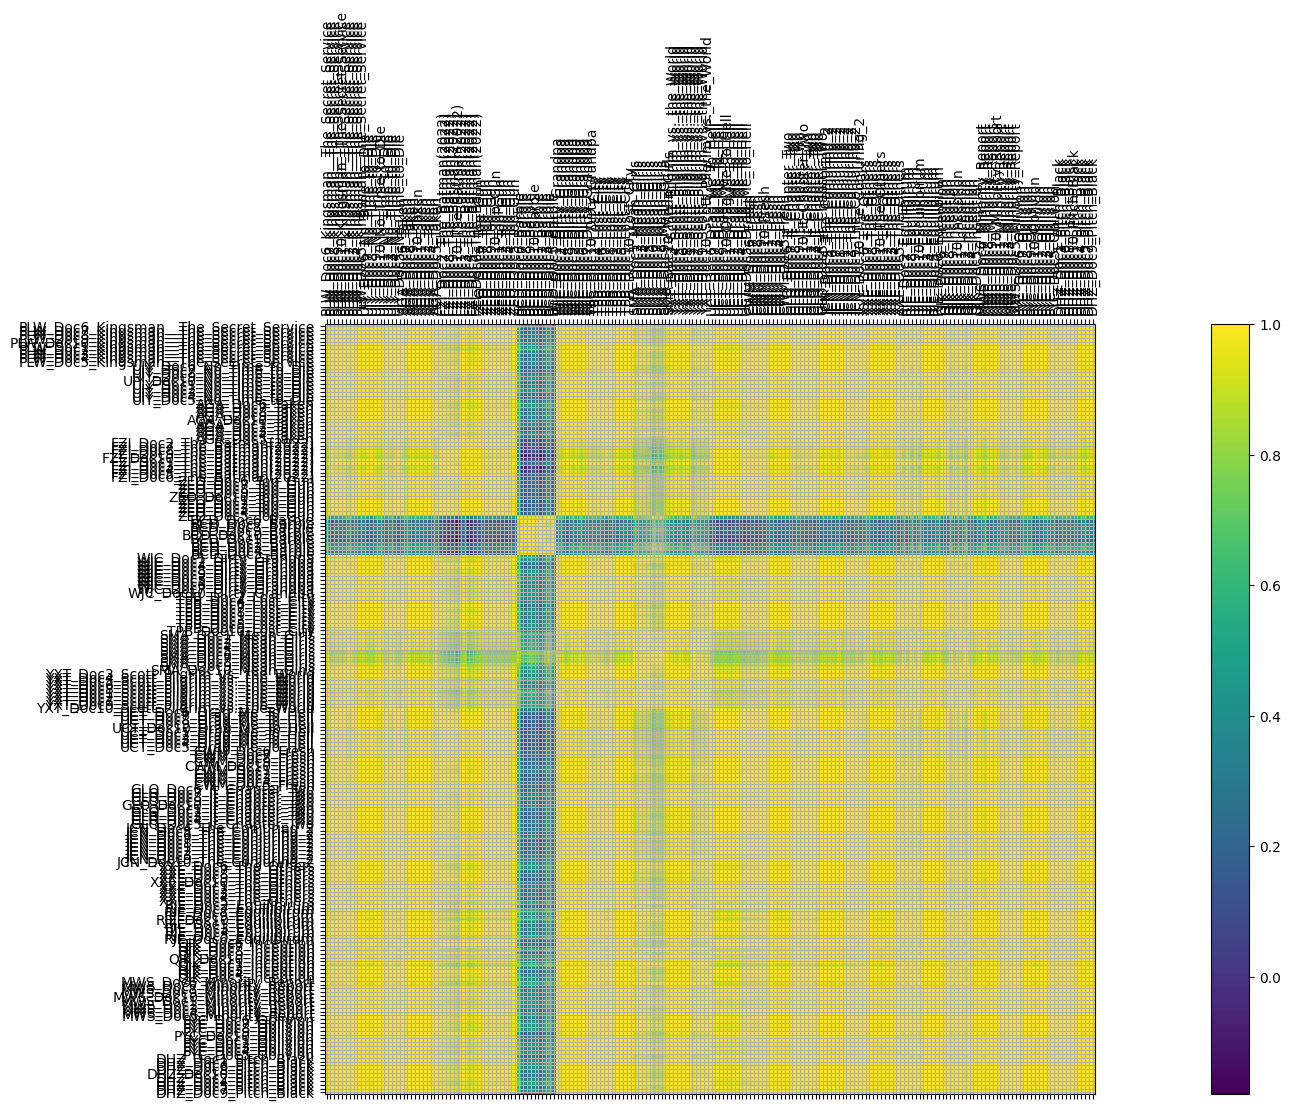

In [50]:
model_2concepts_10words=plot_lsa(2, 10)

### Plotting 6 concepts and 10 words

[(0, '0.531*"movie" + 0.149*"films" + 0.148*"movies" + 0.142*"character" + 0.139*"story" + 0.128*"characters" + 0.127*"horror" + 0.122*"action" + 0.120*"first" + 0.115*"barbie"'), (1, '-0.806*"barbie" + -0.161*"world" + 0.144*"movie" + -0.140*"gerwig" + -0.132*"gosling" + -0.124*"robbie" + -0.120*"barbies" + -0.120*"margot" + 0.111*"batman" + -0.090*"girls"'), (2, '-0.781*"batman" + -0.163*"wayne" + -0.155*"pattinson" + -0.146*"bruce" + -0.137*"reeves" + -0.127*"robert" + 0.104*"maverick" + 0.095*"action" + -0.086*"gotham" + -0.079*"barbie"'), (3, '0.435*"movie" + -0.249*"action" + 0.237*"horror" + -0.213*"maverick" + -0.168*"scott" + -0.154*"films" + -0.136*"world" + -0.126*"character" + 0.125*"scary" + -0.112*"feels"'), (4, '-0.372*"movie" + -0.269*"maverick" + -0.144*"barbie" + 0.143*"girls" + -0.136*"feels" + 0.126*"first" + -0.122*"character" + 0.118*"years" + -0.114*"action" + -0.111*"mavericks"'), (5, '0.484*"girls" + 0.329*"school" + -0.188*"horror" + 0.177*"plastics" + 0.152*"

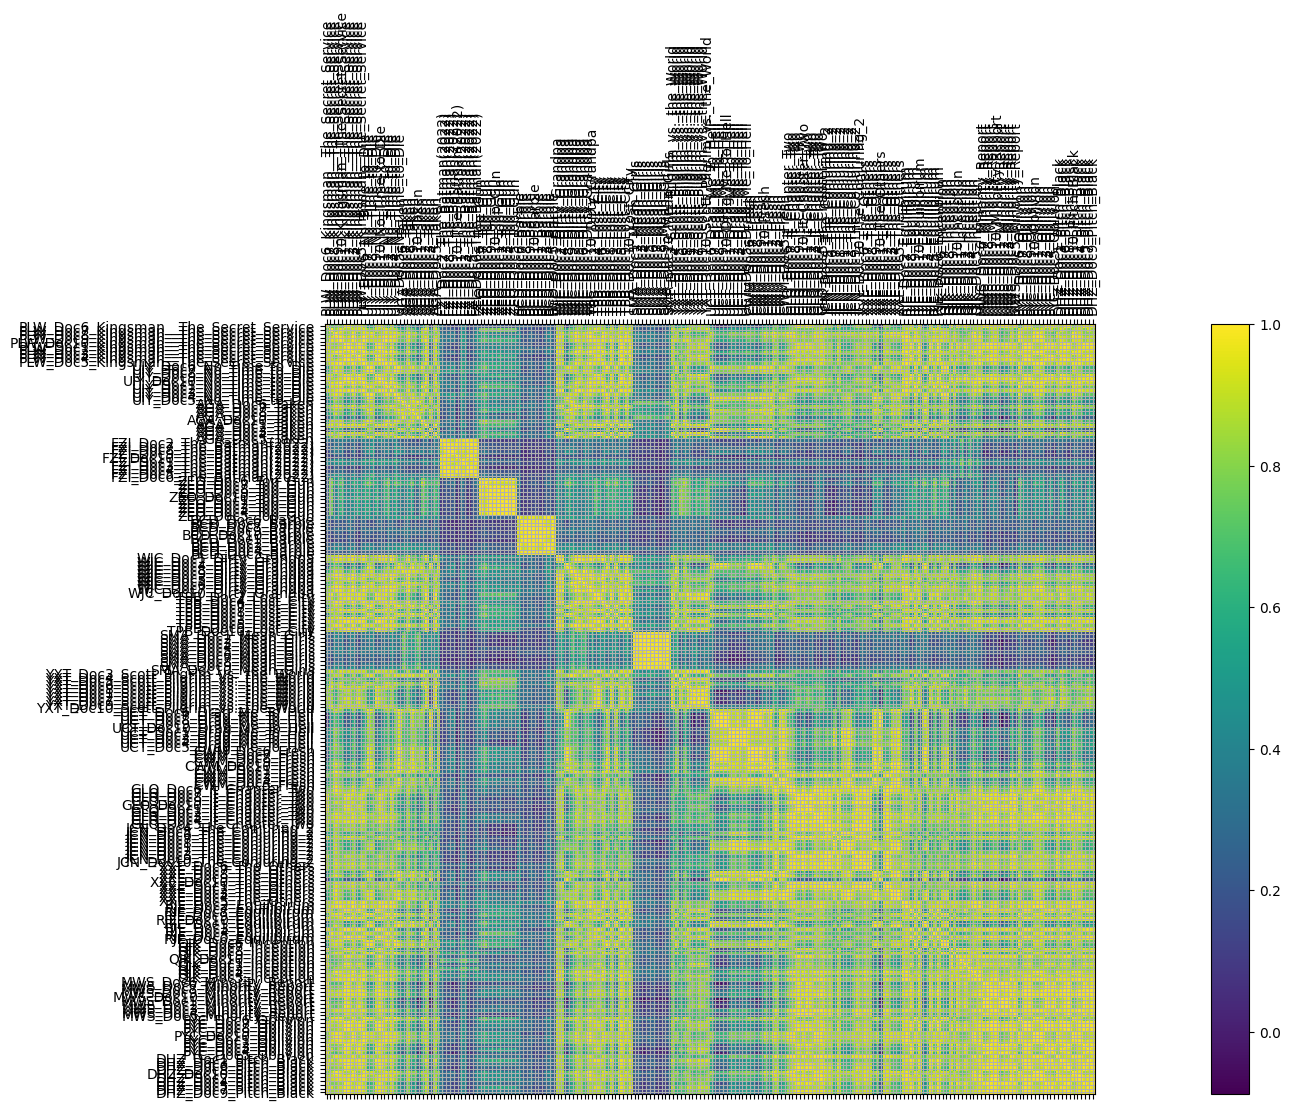

In [51]:
model_6concepts_10words=plot_lsa(6, 10)

### Plotting 20 concepts and 10 words

[(0, '-0.531*"movie" + -0.149*"films" + -0.148*"movies" + -0.142*"character" + -0.139*"story" + -0.128*"characters" + -0.127*"horror" + -0.122*"action" + -0.120*"first" + -0.115*"barbie"'), (1, '-0.806*"barbie" + -0.161*"world" + 0.144*"movie" + -0.140*"gerwig" + -0.132*"gosling" + -0.124*"robbie" + -0.120*"barbies" + -0.120*"margot" + 0.111*"batman" + -0.090*"girls"'), (2, '-0.781*"batman" + -0.163*"wayne" + -0.155*"pattinson" + -0.146*"bruce" + -0.137*"reeves" + -0.127*"robert" + 0.104*"maverick" + 0.095*"action" + -0.086*"gotham" + -0.079*"barbie"'), (3, '-0.435*"movie" + 0.249*"action" + -0.237*"horror" + 0.213*"maverick" + 0.168*"scott" + 0.154*"films" + 0.136*"world" + 0.126*"character" + -0.125*"scary" + 0.112*"feels"'), (4, '-0.372*"movie" + -0.269*"maverick" + -0.144*"barbie" + 0.143*"girls" + -0.136*"feels" + 0.126*"first" + -0.122*"character" + 0.118*"years" + -0.114*"action" + -0.111*"mavericks"'), (5, '-0.484*"girls" + -0.329*"school" + 0.188*"horror" + -0.177*"plastics" +

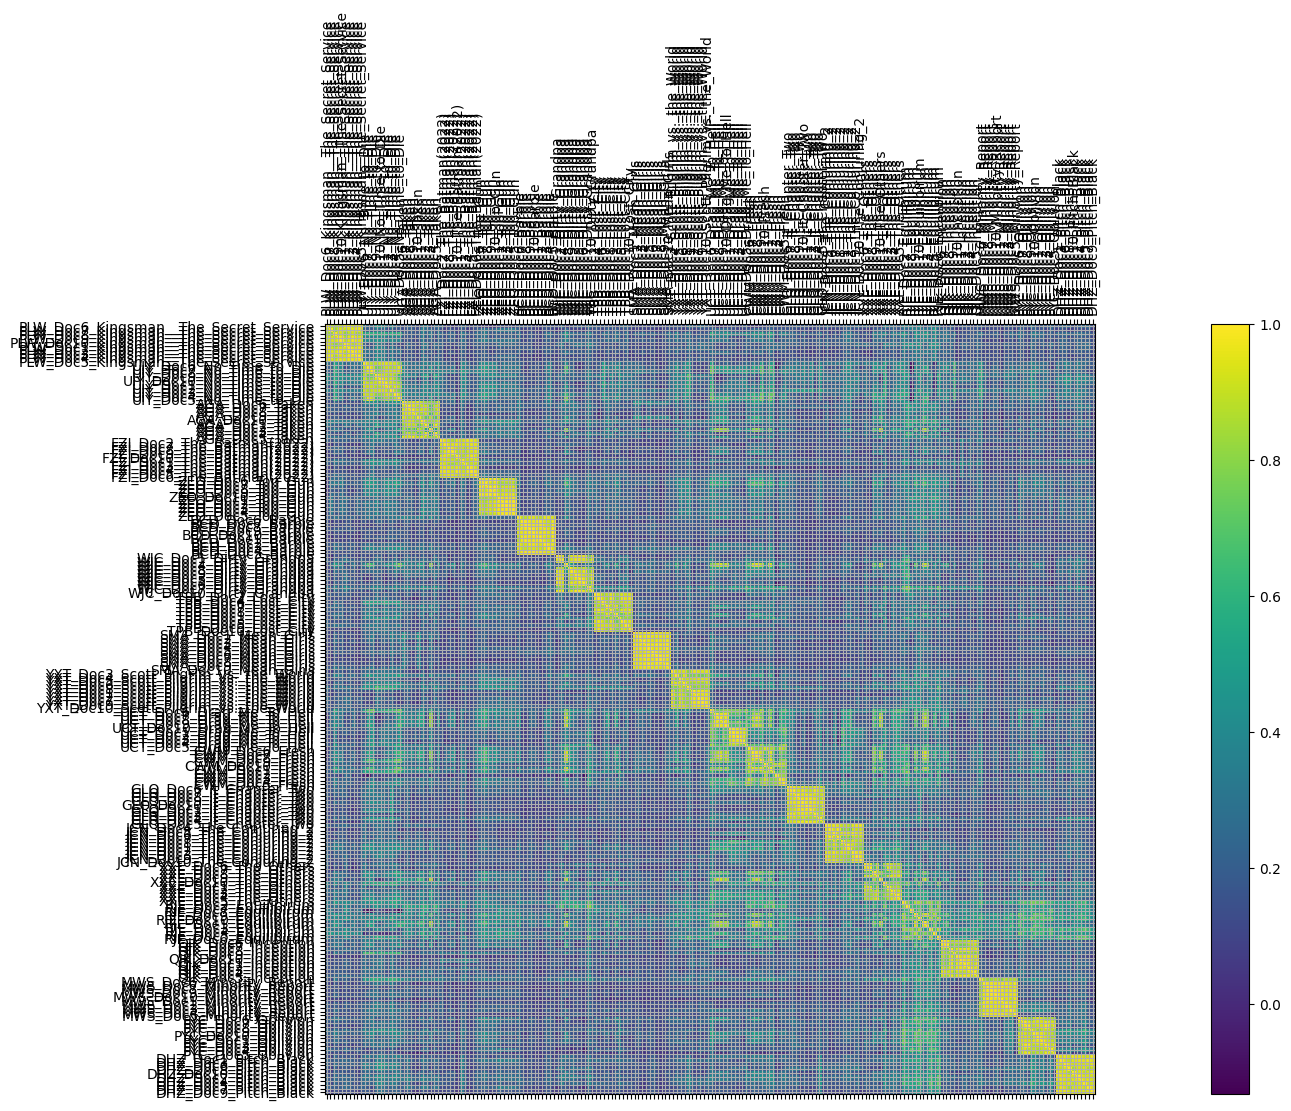

In [52]:
model_20concepts_10words=plot_lsa(20, 10)

### Compare LSA Model Coherence

In [53]:
topics = [6, 2, 1]
coherence_values = []
for t in topics:
    #BARRYC EXPERIMENTAL#1
    #lsamodel,dictionary,index = create_gensim_lsa_model(processed_text,t,10, titles)
    lsamodel,dictionary,index = create_gensim_lsa_model(processed_text,t,10)


    coherence_model_lsa = CoherenceModel(model=lsamodel, dictionary=dictionary, texts=processed_text, coherence='c_v')
    coherence_lsa = coherence_model_lsa.get_coherence()
    coherence_values.append(coherence_lsa)


coherence ={'6 concepts 10 words':coherence_values[0],
           '2 concepts 10 words': coherence_values[1],
           '20 concepts 10 words':coherence_values[2]}

print(coherence)

[(0, '0.531*"movie" + 0.149*"films" + 0.148*"movies" + 0.142*"character" + 0.139*"story" + 0.128*"characters" + 0.127*"horror" + 0.122*"action" + 0.120*"first" + 0.115*"barbie"'), (1, '-0.806*"barbie" + -0.161*"world" + 0.144*"movie" + -0.140*"gerwig" + -0.132*"gosling" + -0.124*"robbie" + -0.120*"barbies" + -0.120*"margot" + 0.111*"batman" + -0.090*"girls"'), (2, '0.781*"batman" + 0.163*"wayne" + 0.155*"pattinson" + 0.146*"bruce" + 0.137*"reeves" + 0.127*"robert" + -0.104*"maverick" + -0.095*"action" + 0.086*"gotham" + 0.079*"barbie"'), (3, '0.435*"movie" + -0.249*"action" + 0.237*"horror" + -0.213*"maverick" + -0.168*"scott" + -0.154*"films" + -0.136*"world" + -0.126*"character" + 0.125*"scary" + -0.112*"feels"'), (4, '-0.372*"movie" + -0.269*"maverick" + -0.144*"barbie" + 0.143*"girls" + -0.136*"feels" + 0.126*"first" + -0.122*"character" + 0.118*"years" + -0.114*"action" + -0.111*"mavericks"'), (5, '0.484*"girls" + 0.329*"school" + -0.188*"horror" + 0.177*"plastics" + 0.152*"lohan"

[(0, '0.531*"movie" + 0.149*"films" + 0.148*"movies" + 0.142*"character" + 0.139*"story" + 0.128*"characters" + 0.127*"horror" + 0.122*"action" + 0.120*"first" + 0.115*"barbie"'), (1, '0.806*"barbie" + 0.161*"world" + -0.144*"movie" + 0.140*"gerwig" + 0.132*"gosling" + 0.124*"robbie" + 0.120*"barbies" + 0.120*"margot" + -0.111*"batman" + 0.090*"girls"')]


[(0, '0.531*"movie" + 0.149*"films" + 0.148*"movies" + 0.142*"character" + 0.139*"story" + 0.128*"characters" + 0.127*"horror" + 0.122*"action" + 0.120*"first" + 0.115*"barbie"')]
{'6 concepts 10 words': 0.4707345495270281, '2 concepts 10 words': 0.5229224951810576, '20 concepts 10 words': 0.26585713968683117}


In [54]:
topics = [3]
coherence_values = []
for t in topics:
    #BARRYC EXPERIMENTAL#1
    #lsamodel,dictionary,index = create_gensim_lsa_model(processed_text,t,10, titles)
    lsamodel,dictionary,index = create_gensim_lsa_model(processed_text,t,10)


    coherence_model_lsa = CoherenceModel(model=lsamodel, dictionary=dictionary, texts=processed_text, coherence='c_v')
    coherence_lsa = coherence_model_lsa.get_coherence()
    coherence_values.append(coherence_lsa)


coherence ={'3 concepts 10 words':coherence_values[0]}


print(coherence)

[(0, '0.531*"movie" + 0.149*"films" + 0.148*"movies" + 0.142*"character" + 0.139*"story" + 0.128*"characters" + 0.127*"horror" + 0.122*"action" + 0.120*"first" + 0.115*"barbie"'), (1, '0.806*"barbie" + 0.161*"world" + -0.144*"movie" + 0.140*"gerwig" + 0.132*"gosling" + 0.124*"robbie" + 0.120*"barbies" + 0.120*"margot" + -0.111*"batman" + 0.090*"girls"'), (2, '0.781*"batman" + 0.163*"wayne" + 0.155*"pattinson" + 0.146*"bruce" + 0.137*"reeves" + 0.127*"robert" + -0.104*"maverick" + -0.095*"action" + 0.086*"gotham" + 0.079*"barbie"')]
{'3 concepts 10 words': 0.5674705792290697}


## Latent Dirichlet Allocation - Research Number of Topics and Number of Words

In [55]:
######################################
#EXPERIMENT WITH THESE PARAMETERS
number_of_topics=4
words=20
#####################################

In [56]:
######################################
#EXPERIMENT WITH THESE PARAMETERS
number_of_topics=3
words=10
#####################################

[(0, '0.009*"movie" + 0.004*"story" + 0.004*"batman" + 0.004*"barbie" + 0.003*"horror" + 0.003*"really" + 0.003*"first" + 0.003*"character" + 0.003*"films" + 0.003*"world"'), (1, '0.010*"movie" + 0.005*"movies" + 0.004*"horror" + 0.003*"barbie" + 0.003*"films" + 0.002*"first" + 0.002*"batman" + 0.002*"people" + 0.002*"christine" + 0.002*"years"'), (2, '0.007*"movie" + 0.004*"action" + 0.004*"films" + 0.003*"character" + 0.003*"world" + 0.003*"girls" + 0.003*"characters" + 0.003*"maverick" + 0.003*"thats" + 0.003*"school"')]


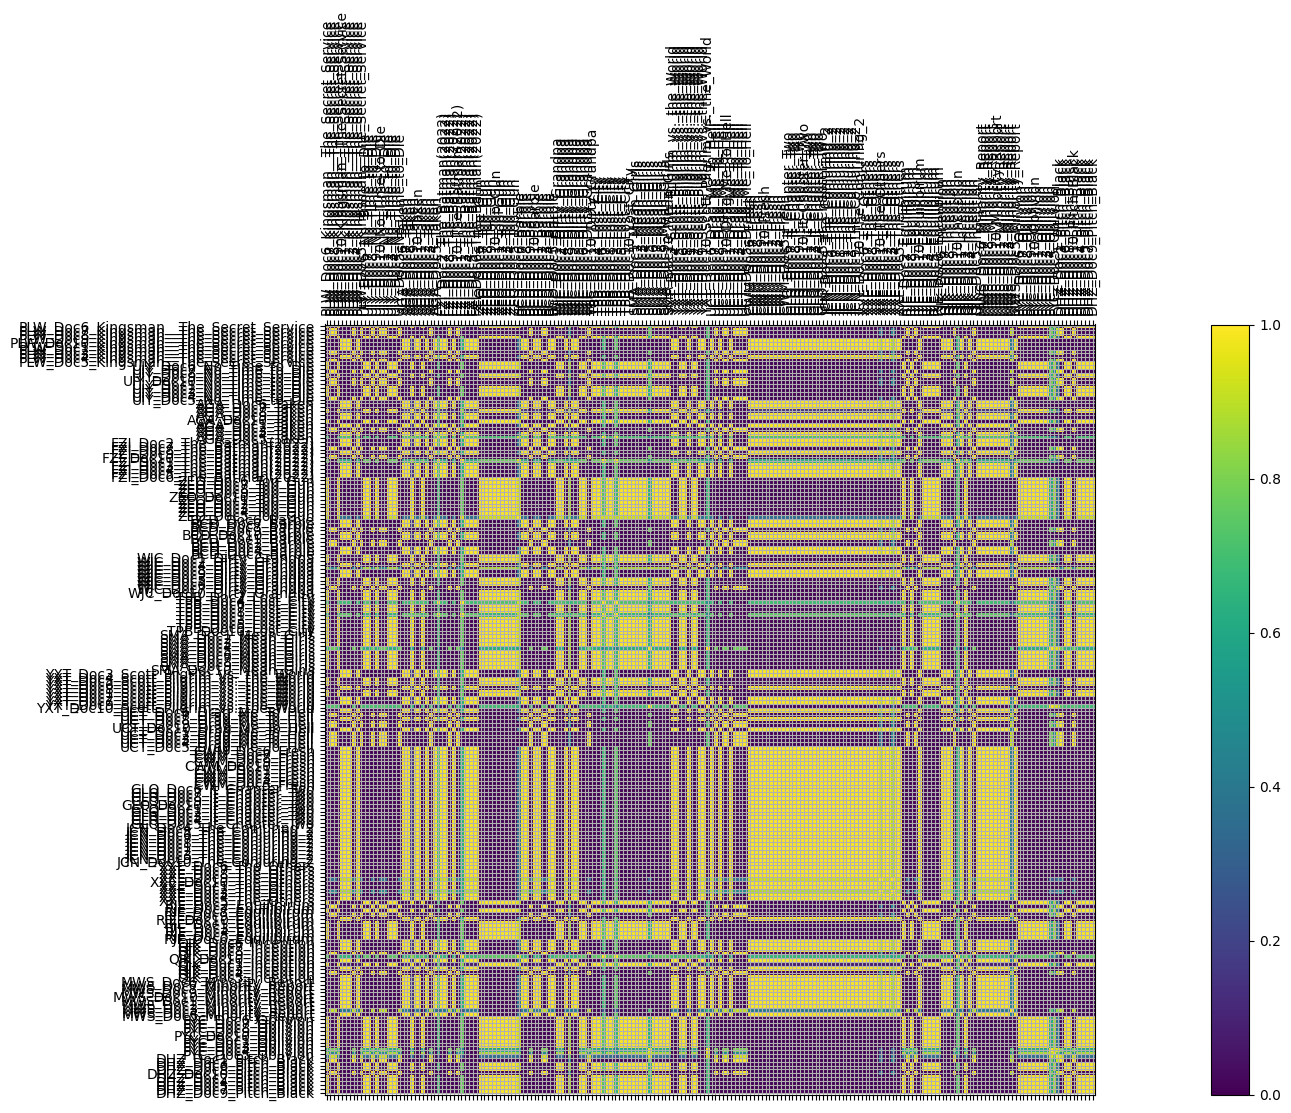

In [57]:
# BARRYC EXPERIMENTAL#1
#model2,dictionary2,index2,doctermmatrix2=create_gensim_lda_model(processed_text,number_of_topics,words,titles)
model2,dictionary2,index2,doctermmatrix2=create_gensim_lda_model(processed_text,number_of_topics,words)

for doc in processed_text:
    vec_bow2 = dictionary2.doc2bow(doc)
    vec2 = model2[vec_bow2]  # convert the query to embedded space
    sims2 = index2[vec2]  # perform a similarity query against the corpus
    #print(list(enumerate(sims2)))

fig, ax = plt.subplots(figsize=(30, 10))
cax = ax.matshow(index2, interpolation='nearest')
ax.grid(True)
plt.xticks(range(len(processed_text)), titles, rotation=90);
plt.yticks(range(len(processed_text)), titles);
fig.colorbar(cax)
plt.show()

### Compare LDA Model Coherence

In [58]:
topics = [6, 2, 10]
coherence_values = []
for t in topics:
    #BARRYC EXPERIMENTAL#1
    #ldamodel,dictionary,index, matrix = create_gensim_lda_model(processed_text,t,10,titles)
    ldamodel,dictionary,index, matrix = create_gensim_lda_model(processed_text,t,10)


    coherence_model_lda = CoherenceModel(model=ldamodel, dictionary=dictionary, texts=processed_text, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_values.append(coherence_lda)


coherence ={'6 topic 10 words':coherence_values[0],
           '2 topic 10 words': coherence_values[1],
           '20 topic 10 words':coherence_values[2]}

print(coherence)

[(0, '0.009*"movie" + 0.005*"story" + 0.004*"films" + 0.004*"batman" + 0.003*"first" + 0.003*"really" + 0.003*"people" + 0.003*"world" + 0.003*"doesnt" + 0.003*"horror"'), (1, '0.015*"movie" + 0.006*"movies" + 0.004*"horror" + 0.003*"people" + 0.003*"really" + 0.002*"thats" + 0.002*"batman" + 0.002*"eggsy" + 0.002*"scenes" + 0.002*"years"'), (2, '0.009*"movie" + 0.004*"action" + 0.003*"films" + 0.003*"world" + 0.003*"girls" + 0.003*"scott" + 0.003*"character" + 0.003*"thats" + 0.003*"first" + 0.003*"school"'), (3, '0.013*"barbie" + 0.007*"movie" + 0.005*"world" + 0.004*"girls" + 0.004*"characters" + 0.003*"films" + 0.003*"character" + 0.003*"jason" + 0.002*"black" + 0.002*"every"'), (4, '0.009*"movie" + 0.006*"horror" + 0.004*"feels" + 0.004*"batman" + 0.004*"films" + 0.003*"story" + 0.003*"character" + 0.003*"little" + 0.003*"action" + 0.003*"scenes"'), (5, '0.006*"pennywise" + 0.005*"chapter" + 0.005*"losers" + 0.005*"movie" + 0.004*"daughter" + 0.004*"paris" + 0.004*"first" + 0.004*

[(0, '0.009*"movie" + 0.003*"story" + 0.003*"films" + 0.003*"batman" + 0.003*"first" + 0.003*"horror" + 0.003*"really" + 0.003*"character" + 0.003*"world" + 0.003*"characters"'), (1, '0.008*"movie" + 0.003*"films" + 0.003*"movies" + 0.003*"action" + 0.003*"character" + 0.003*"world" + 0.002*"characters" + 0.002*"barbie" + 0.002*"first" + 0.002*"story"')]


[(0, '0.013*"movie" + 0.007*"batman" + 0.004*"fresh" + 0.004*"films" + 0.004*"horror" + 0.004*"story" + 0.004*"first" + 0.004*"inception" + 0.004*"character" + 0.004*"people"'), (1, '0.009*"movie" + 0.005*"movies" + 0.003*"earth" + 0.003*"years" + 0.003*"preston" + 0.002*"minutes" + 0.002*"would" + 0.002*"characters" + 0.002*"james" + 0.002*"story"'), (2, '0.009*"movie" + 0.007*"action" + 0.005*"maverick" + 0.005*"girls" + 0.005*"films" + 0.004*"school" + 0.004*"character" + 0.003*"characters" + 0.003*"scott" + 0.003*"world"'), (3, '0.008*"jason" + 0.005*"grandpa" + 0.005*"dirty" + 0.004*"films" + 0.004*"characters" + 0.004*"movie" + 0.004*"comedy" + 0.003*"efron" + 0.003*"things" + 0.003*"world"'), (4, '0.010*"movie" + 0.005*"feels" + 0.005*"horror" + 0.004*"character" + 0.004*"anderton" + 0.004*"story" + 0.004*"conjuring" + 0.003*"characters" + 0.003*"another" + 0.003*"precrime"'), (5, '0.006*"daughter" + 0.006*"movie" + 0.006*"paris" + 0.004*"batman" + 0.004*"girls" + 0.003*"first" 

In [59]:
topics = [3]
coherence_values = []
for t in topics:
    #BARRYC EXPERIMENTAL#1
    #ldamodel,dictionary,index, matrix = create_gensim_lda_model(processed_text,t,10,titles)
    ldamodel,dictionary,index, matrix = create_gensim_lda_model(processed_text,t,10)


    coherence_model_lda = CoherenceModel(model=ldamodel, dictionary=dictionary, texts=processed_text, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_values.append(coherence_lda)


coherence ={'3 topic 10 words':coherence_values[0]}

print(coherence)

[(0, '0.009*"movie" + 0.004*"story" + 0.004*"batman" + 0.004*"barbie" + 0.003*"horror" + 0.003*"really" + 0.003*"first" + 0.003*"character" + 0.003*"films" + 0.003*"world"'), (1, '0.010*"movie" + 0.005*"movies" + 0.004*"horror" + 0.003*"barbie" + 0.003*"films" + 0.002*"first" + 0.002*"batman" + 0.002*"people" + 0.002*"christine" + 0.002*"years"'), (2, '0.007*"movie" + 0.004*"action" + 0.004*"films" + 0.003*"character" + 0.003*"world" + 0.003*"girls" + 0.003*"characters" + 0.003*"maverick" + 0.003*"thats" + 0.003*"school"')]
{'3 topic 10 words': 0.27334459317628756}


In [60]:
topics = [3]
coherence_values = []
for t in topics:
    #BARRYC EXPERIMENTAL#1
    #ldamodel,dictionary,index, matrix = create_gensim_lda_model(processed_text,t,10,titles)
    ldamodel,dictionary,index, matrix = create_gensim_lda_model(processed_text,t,10)


    coherence_model_lda = CoherenceModel(model=ldamodel, dictionary=dictionary, texts=processed_text, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_values.append(coherence_lda)


coherence ={'3 topic 10 words':coherence_values[0]}


print(coherence)

[(0, '0.009*"movie" + 0.004*"story" + 0.004*"batman" + 0.004*"barbie" + 0.003*"horror" + 0.003*"really" + 0.003*"first" + 0.003*"character" + 0.003*"films" + 0.003*"world"'), (1, '0.010*"movie" + 0.005*"movies" + 0.004*"horror" + 0.003*"barbie" + 0.003*"films" + 0.002*"first" + 0.002*"batman" + 0.002*"people" + 0.002*"christine" + 0.002*"years"'), (2, '0.007*"movie" + 0.004*"action" + 0.004*"films" + 0.003*"character" + 0.003*"world" + 0.003*"girls" + 0.003*"characters" + 0.003*"maverick" + 0.003*"thats" + 0.003*"school"')]
{'3 topic 10 words': 0.27334459317628756}


# **BERTopic**

This section of the code demonstrates the BERTopic library to extract topics and visualize the distribution and relationships between them.

You've already done preprocessing earlier by cleaning the text by removing punctuation, filtering out stop words and short tokens, and converting text to lowercase. You could also try with the raw sentences too!

Then there is topic modeling with BERTopic to identify and analyze underlying themes in the dataset.

&nbsp;

In [61]:
   pip install bertopic

In [62]:
#pip install --upgrade openai

In [63]:
import re,string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import matplotlib.pyplot as plt

import pandas as pd
import os
import numpy as np
from bertopic import BERTopic
import warnings
warnings.filterwarnings('ignore')

In [64]:
# ALREADY DONE EARLIER

# import nltk
# nltk.download('stopwords')

#functions used to process text and create the required TFIDF and Doc2vec Matrices
# def clean_doc(doc):
#     ...

# def final_processed_text(doc):
#     #this is a function to join the processed text back
#     ...

In [65]:
# ALREADY DONE EARLIER

# #read in class corpus csv into python
# data=pd.read_csv(r'MSDS453_QA_20220906.csv')

# #adding two columns to the dataframe to store the processed text and tokenized text
# data['processed_text'] = data['Text'].apply(lambda x: clean_doc(x))

# #creating final processed text variables for matrix creation
# final_processed_text = [' '.join(x) for x in data['processed_text'].tolist()]
# titles = data['Movie Title'].tolist()
# processed_text = data['processed_text'].tolist()

In [66]:
len(final_processed_text)

200

In [67]:
final_processed_text[1]

'reason kingsman secret service leaves feeling rooked wastes onceinanactorslifetime opportunity casting colin firth lethal gentleman superspy stranding without elegant derringdo catching lightning bottle opening stopper letting flash firth plays harry galahad member independent british secret service patterns arthurs round table michael caine plays chief arthur firth focused primed action passes master movie strategy audiences meant smile seeing beloved humanist pubfull thugs addled fundamentalists audiences movie rrated identify galahads protege eggsy unwin taron egerton bright strong goodhearted north london housing project eggsy kingsman agent handful comrades including harry agent takes cause hoping honor prove agency reinvigorate proletarian blood films scattered semifunny riffs harry eggsy whether knows trading places femme nikita pretty woman answer nobut eggsy preferred firths hyperrational magician played henry higgins stones psychic eliza doolittle magic moonlight kingsman wr

In [68]:
from bertopic import BERTopic
topic_model = BERTopic(min_topic_size=2)

In [69]:
topics, probs = topic_model.fit_transform(final_processed_text)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [70]:
topic_model.get_topic_info()

Topic  Count                                     Name  \
0      -1      7           -1_barbie_movie_going_children   
1       0     12  0_conjuring_warrens_lorraine_amityville   
2       1     10            1_kingsman_eggsy_firth_secret   
3       2     10          2_bullock_loretta_tatum_romance   
4       3     10           3_oblivion_earth_drones_cruise   
5       4     10      4_anderton_minority_report_precrime   
6       5     10           5_inception_dreams_nolan_dream   
7       6     10    6_preston_equilibrium_emotions_matrix   
8       7     10         7_pennywise_chapter_losers_derry   
9       8     10            8_scott_pilgrim_ramona_wright   
10      9     10            9_craig_craigs_spectre_casino   
11     10     10           10_girls_school_plastics_lohan   
12     11     10       11_maverick_feels_action_mavericks   
13     12     10         12_batman_reeves_pattinson_wayne   
14     13     10              13_pitch_black_alien_planet   
15     14      9             14_jason_grandpa_dirty_efron   
16     15      8      15_fresh_sebastian_edgarjones_daisy   
17     16      7         16_horror_christine_raimi_lohman   
18     17      6           17_grace_others_house_amenabar   
19     18      5          18_daughter_paris_neeson_friend   
20     19      4             19_movie_people_really_wasnt   
21     20      4           20_barbie_gerwig_gosling_greta   
22     21      4         21_barbie_robbie_barbies_gosling   
23     22      4           22_bryan_taken_daughter_neeson   

                                       Representation  \
0   [barbie, movie, going, children, lifetime, wor...   
1   [conjuring, warrens, lorraine, amityville, hor...   
2   [kingsman, eggsy, firth, secret, vaughn, servi...   
3   [bullock, loretta, tatum, romance, sandra, rad...   
4   [oblivion, earth, drones, cruise, victoria, sc...   
5   [anderton, minority, report, precrime, spielbe...   
6   [inception, dreams, nolan, dream, nolans, chri...   
7   [preston, equilibrium, emotions, matrix, emoti...   
8   [pennywise, chapter, losers, derry, muschietti...   
9   [scott, pilgrim, ramona, wright, scotts, micha...   
10  [craig, craigs, spectre, casino, franchise, ro...   
11  [girls, school, plastics, lohan, queen, regina...   
12  [maverick, feels, action, mavericks, aerial, e...   
13  [batman, reeves, pattinson, wayne, bruce, goth...   
14  [pitch, black, alien, planet, crash, eclipse, ...   
15  [jason, grandpa, dirty, efron, comedy, grandfa...   
16  [fresh, sebastian, edgarjones, daisy, dating, ...   
17  [horror, christine, raimi, lohman, movie, scar...   
18  [grace, others, house, amenabar, kidman, child...   
19  [daughter, paris, neeson, friend, excia, taken...   
20  [movie, people, really, wasnt, maybe, thats, c...   
21  [barbie, gerwig, gosling, greta, margot, barbi...   
22  [barbie, robbie, barbies, gosling, margot, ger...   
23  [bryan, taken, daughter, neeson, mills, amanda...   

                                  Representative_Docs  
0   [scenes overall predictable things sense chara...  
1   [prologue conjuring effective sequence james m...  
2   [kingsman secret service starring natty colin ...  
3   [sandra bullock channing tatum revive romcomad...  
4   [squirming cruise scifi vehicle oblivion flash...  
5   [steven spielbergs minority report realizes po...  
6   [dreams theyre infantile heaven knows artist l...  
7   [science fiction genre creating visions nightm...  
8   [stephen kings colossal course thousand pages ...  
9   [normally opinions longer paragraph movies hou...  
10  [latest appearance daniel craig james movie mo...  
11  [refuse believe someone smarts would content s...  
12  [remembered iconic movie revisited today doesn...  
13  [batman fighting crime fighting sleep gonna pr...  
14  [making purely scifi action movie becoming cer...  
15  [pinpoint exactly began comedy worse within de...  
16  [dating world tough unpredictable especially c...  
17  [intense opening scene stellar shocking 

In [71]:
topic_model.visualize_barchart()

In [72]:
topic_model.visualize_heatmap()

In [73]:
topic_model.get_document_info(final_processed_text)

Document  Topic  \
0    complaint always dogged james franchise years ...      1   
1    reason kingsman secret service leaves feeling ...      1   
2    kingsman secret service makes rules along take...      1   
3    silly sadistic finally little galling kingsman...      1   
4    amused james abdicated title thats millardave ...      1   
..                                                 ...    ...   
195  genre pitch black rattletrap spook alien thats...     13   
196  sometimes movie value casablanca shocking soun...     13   
197  pitch black another alien formula group people...     13   
198  making purely scifi action movie becoming cert...     13   
199  diesel suddenly largely unknown actor whose si...     13   

                              Name  \
0    1_kingsman_eggsy_firth_secret   
1    1_kingsman_eggsy_firth_secret   
2    1_kingsman_eggsy_firth_secret   
3    1_kingsman_eggsy_firth_secret   
4    1_kingsman_eggsy_firth_secret   
..                             ...   
195    13_pitch_black_alien_planet   
196    13_pitch_black_alien_planet   
197    13_pitch_black_alien_planet   
198    13_pitch_black_alien_planet   
199    13_pitch_black_alien_planet   

                                        Representation  \
0    [kingsman, eggsy, firth, secret, vaughn, servi...   
1    [kingsman, eggsy, firth, secret, vaughn, servi...   
2    [kingsman, eggsy, firth, secret, vaughn, servi...   
3    [kingsman, eggsy, firth, secret, vaughn, servi...   
4    [kingsman, eggsy, firth, secret, vaughn, servi...   
..                                                 ...   
195  [pitch, black, alien, planet, crash, eclipse, ...   
196  [pitch, black, alien, planet, crash, eclipse, ...   
197  [pitch, black, alien, planet, crash, eclipse, ...   
198  [pitch, black, alien, planet, crash, eclipse, ...   
199  [pitch, black, alien, planet, crash, eclipse, ...   

                                   Representative_Docs  \
0    [kingsman secret service starring natty colin ...   
1    [kingsman secret service starring natty colin ...   
2    [kingsman secret service starring natty colin ...   
3    [kingsman secret service starring natty colin ...   
4    [kingsman secret service starring natty colin ...   
..                                                 ...   
195  [making purely scifi action movie becoming cer...   
196  [making purely scifi action movie becoming cer...   
197  [making purely scifi action movie becoming cer...   
198  [making purely scifi action movie becoming cer...   
199  [making purely scifi action movie becoming cer...   

                                           Top_n_words  Probability  \
0    kingsman - eggsy - firth - secret - vaughn - s...     0.509578   
1    kingsman - eggsy - firth - secret - vaughn - s...     0.636656   
2    kingsman - eggsy - firth - secret - vaughn - s...     0.391488   
3    kingsman - eggsy - firth - secret - vaughn - s...     0.509578   
4    kingsman - eggsy - firth - secret - vaughn - s...     0.506886   
..                                                 ...          ...   
195  pitch - black - alien - planet - crash - eclip...     1.000000   
196  pitch - black - alien - planet - crash - eclip...     0.849183   
197  pitch - black - alien - planet - crash - eclip...     0.722489   
198  pitch - black - alien - planet - crash - eclip...     1.000000   
199  pitch - black - alien - planet - crash - eclip...     1.000000   

     Representative_document  
0                      False  
1                       True  
2                      False  
3                      False  
4                      False  
..                       ...  
195                    False  
196                    False  
197                    False  
198                     True  
199                     True  

[200 rows x 8 columns]

# **6. Cluster Model Research: KMeans, SVM, Logistic, Naive Bayes, Randomforest, BERT**


## NLP Supervised and Unsupervised Learning Methods:
1. K-Means Clustering (Unsupervised)
2. Support Vector Machines (SVMs) (Supervised)
3. (Multinomial) Naïve Bayes (MultinomialNB) (Supervised)
4. Logistic Regression (Supervised)

### Generate TF-IDF For Analysis

In [74]:
tfidf_matrix = tfidf(final_processed_text, titles, ngram_range = (1,1))

### KMeans Clustering

<div class="alert alert-block alert-success">
    <b>sklearn.cluster.KMeans</b>:<br>
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html<br><br>
<b>KMeans Default Parameters</b>:<br>
    class sklearn.cluster.KMeans(n_clusters=8, *, init='k-means++', n_init=10, max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='auto')
    </div>

In [75]:
cluster_title,clusters,k_means_df = k_means(titles, tfidf_matrix, k=4)

In [76]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"  # Disable parallelism

### Access Each Cluster - Changing Dictionary KeyValue from 0 to k

In [77]:
cluster_title[1]

['BCD_Doc6_Barbie',
 'BCD_Doc7_Barbie',
 'BCD_Doc8_Barbie',
 'BCD_Doc9_Barbie',
 'BCD_Doc10_Barbie',
 'BCD_Doc1_Barbie',
 'BCD_Doc2_Barbie',
 'BCD_Doc3_Barbie',
 'BCD_Doc4_Barbie',
 'BCD_Doc5_Barbie']

In [78]:
# def plot_tfidf_matrix_no_titles(tfidf_matrix):
#     mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
#     dist = 1 - cosine_similarity(tfidf_matrix)
#     pos = mds.fit_transform(dist)
#     xs, ys = pos[:, 0], pos[:, 1]

#     fig, ax = plt.subplots(figsize=(20, 20))
#     ax.margins(0.05)

#     df = pd.DataFrame(dict(x=xs, y=ys, label=clusters))

#     groups = df.groupby('label')
#     for name, group in groups:
#         r = random.random()
#         b = random.random()
#         g = random.random()
#         color = (r, g, b)

#         ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, color=color, mec='none')
#         ax.set_aspect('auto')
#         ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
#         ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

#     plt.show()

# # Call the plotting function without titles or cluster labels
# plot_tfidf_matrix_no_titles(tfidf_matrix)

### Generate Labels for Supervised Learning Models

In [79]:
labels = data['Review Type (pos or neg)'].apply(lambda x: 0 if x.lower().split(' ')[0] == 'negative' else 1)
print(labels)

Doc_ID
166    0
167    0
168    0
169    0
170    0
      ..
262    1
264    1
265    1
267    1
269    1
Name: Review Type (pos or neg), Length: 200, dtype: int64


### Support Vector Machines

<div class="alert alert-block alert-success">
    <b>Support vector machines (SVMs)</b>:<br>
https://scikit-learn.org/stable/modules/svm.html<br><br>
    Set of supervised learning methods used for classification, regression and outliers detection
    </div>

In [80]:
classifiers(tfidf_matrix, labels, 'svm')

svm


0.5

### Logistic Regression Model

<div class="alert alert-block alert-success">
    <b>sklearn.linear_model.LogisticRegression</b>:<br>
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html<br><br>
<b>Logistic Regression Default Parameters</b>:<br>
    class sklearn.linear_model.LogisticRegression(penalty='l2', *, dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
    </div>

In [81]:
classifiers(tfidf_matrix, labels, 'logistic')

logistic


0.4

### Naive Bayes

<div class="alert alert-block alert-success">
    <b>Naive Bayes</b>:<br>
https://scikit-learn.org/stable/modules/naive_bayes.html<br><br>
    Naive Bayes methods are a set of supervised learning algorithms based on applying Bayes’ theorem with the “naive” assumption of conditional independence between every pair of features given the value of the class variable.
    </div>

In [82]:
classifiers(tfidf_matrix, labels, 'naive_bayes')

naive_bayes


0.45

### Random Forest

<div class="alert alert-block alert-success">
    <b>sklearn.ensemble.RandomForestClassifier</b>:<br>
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html<br><br>
<b>RandomForest Classifier Default Parameters</b>:<br>
    class sklearn.ensemble.RandomForestClassifier(n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)
    </div>

In [83]:
classifiers(tfidf_matrix, labels, 'randomforest')

randomforest


0.55

### BERT Pre-Trained Binary Classification (Sentiment-Analysis)

We use the pre-trained DistilBERT model "sentiment-analysis" fine-tuned for sentiment analysis to categorize text sentiments into positive, negative, or neutral.

https://wellsr.com/python/hugging-face-pipelines-for-python-natural-language-processing/

In [84]:
def bert_classifier_binary(texts, labels):
    # Initialize the sentiment-analysis pipeline
    classifier = pipeline("sentiment-analysis")

    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.10, random_state=42)

    # Perform sentiment analysis
    results = classifier(X_test, truncation=True)

    # Map BERT's output to binary labels
    predictions = [0 if result['label'] == 'NEGATIVE' else 1 for result in results]

    # Calculate accuracy
    accuracy = accuracy_score(y_test, predictions)
    print(f"Binary Classification Accuracy: {accuracy}")
    return accuracy

In [85]:
# How about the raw text?
raw_text = [text.strip().lower() for text in data['Text']]

raw_text[:1]

['one complaint that has always dogged the james bond franchise over the years is the inescapable fact that while the films seem to be loaded with gratuitous sex and violence in theory, they never quite manage to show them in any great detail. obviously, the decision to imply more than display has served the producers for more than a half-century, but can you imagine what it would be like if a bond film were to include all the seamier elements that they have only hinted at in the past? the early word on the over-the-top action-comedy "kingsman: the secret service" seemed to suggest that it would pay homage to the bond films of oldthe ones made before the series took its turn towards the comparatively serious with the arrival of daniel craigwhile including all the good parts that had been largely absent in the past. alas, it seems to have taken its inspiration from one of the lesser roger moore efforts than the classic connerys and the result is a fitfully amusing but increasing tedious

In [86]:
import re

def clean_non_ascii(text):
    # Replace common non-ASCII characters with their ASCII equivalents
    text = text.replace('\x93', '"').replace('\x94', '"')  # Smart double quotes
    text = text.replace('\x91', "'").replace('\x92', "'")  # Smart single quotes
    text = text.replace('\x96', '-').replace('\x97', '-')  # Long dashes

    # Remove any remaining non-ASCII characters
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    return text

raw_text_cleaned = [clean_non_ascii(text) for text in raw_text]
raw_text_cleaned[:1]

['one complaint that has always dogged the james bond franchise over the years is the inescapable fact that while the films seem to be loaded with gratuitous sex and violence in theory, they never quite manage to show them in any great detail. obviously, the decision to imply more than display has served the producers for more than a half-century, but can you imagine what it would be like if a bond film were to include all the seamier elements that they have only hinted at in the past? the early word on the over-the-top action-comedy "kingsman: the secret service" seemed to suggest that it would pay homage to the bond films of oldthe ones made before the series took its turn towards the comparatively serious with the arrival of daniel craigwhile including all the good parts that had been largely absent in the past. alas, it seems to have taken its inspiration from one of the lesser roger moore efforts than the classic connerys and the result is a fitfully amusing but increasing tedious

In [87]:
# Compare raw text with final processed text:

data['final_processed_text'] = final_processed_text

data['raw_text'] = raw_text
#data['raw_text'] = raw_text_cleaned

comparison_df = pd.DataFrame({
    'Label': labels,
    'Processed_Text': data['final_processed_text'],
    'Raw_Text': data['raw_text']
})

print(comparison_df)


        Label                                     Processed_Text  \
Doc_ID                                                             
166         0  complaint always dogged james franchise years ...   
167         0  reason kingsman secret service leaves feeling ...   
168         0  kingsman secret service makes rules along take...   
169         0  silly sadistic finally little galling kingsman...   
170         0  amused james abdicated title thats millardave ...   
...       ...                                                ...   
262         1  genre pitch black rattletrap spook alien thats...   
264         1  sometimes movie value casablanca shocking soun...   
265         1  pitch black another alien formula group people...   
267         1  making purely scifi action movie becoming cert...   
269         1  diesel suddenly largely unknown actor whose si...   

                                                 Raw_Text  
Doc_ID                                                 

In [88]:
bert_classifier_binary(raw_text, labels)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Binary Classification Accuracy: 0.75


0.75

In [89]:
bert_classifier_binary(raw_text_cleaned, labels)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Binary Classification Accuracy: 0.75


0.75

In [90]:
bert_classifier_binary(final_processed_text, labels)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Binary Classification Accuracy: 0.5


0.5

### BERT Pre-Trained Multiple Classification (Genre)

Our genre classification utilizes a BERT-based uncased model to distinguish text genres. This approach capitalizes on BERT's deep semantic understanding from uncased text, aiming for genre identification.

https://huggingface.co/google-bert/bert-base-uncased

In [91]:
def bert_classifier_multiple(texts, labels):
    # Encode labels
    encoder = LabelEncoder()
    encoded_labels = encoder.fit_transform(labels)

    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(texts, encoded_labels, test_size=0.20, random_state=42)

    # Load a tokenizer and model suited for your multi-class task
    #tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
    #tokenizer = AutoTokenizer.from_pretrained("bert-large-uncased")
    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
    #model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(encoder.classes_))
    #model = AutoModelForSequenceClassification.from_pretrained("bert-large-uncased", num_labels=len(encoder.classes_))
    model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=len(encoder.classes_))

    # Initialize the pipeline
    classifier = pipeline("text-classification", model=model, tokenizer=tokenizer)

    # Perform classification
    results = classifier(X_test, truncation=True)

    # Decode predictions to original labels
    predictions = [int(result['label'].split('_')[-1]) for result in results]
    decoded_predictions = encoder.inverse_transform(predictions)

    # Calculate accuracy
    decoded_y_test = encoder.inverse_transform(y_test)
    accuracy = accuracy_score(decoded_y_test, decoded_predictions)
    print(f"Multi-class Classification Accuracy: {accuracy}")
    return accuracy


In [92]:
bert_classifier_multiple(final_processed_text, data["Genre of Movie"])

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Multi-class Classification Accuracy: 0.225


0.225

In [93]:
bert_classifier_multiple(raw_text, data["Genre of Movie"])

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Multi-class Classification Accuracy: 0.225


0.225

In [94]:
bert_classifier_multiple(raw_text_cleaned, data["Genre of Movie"])

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Multi-class Classification Accuracy: 0.175


0.175

### Confusion Matrix

This code snippet generates a confusion matrix to visually evaluate the performance of our classification model by comparing the actual versus predicted labels.

In [95]:
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

def bert_classifier_multiple(texts, labels):
    # Initialize and fit the label encoder
    encoder = LabelEncoder()
    encoded_labels = encoder.fit_transform(labels)

    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(texts, encoded_labels, test_size=0.10, random_state=42)

    # Load a tokenizer and model suited for the multi-class task
    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
    #tokenizer = AutoTokenizer.from_pretrained("bert-large-uncased")

    model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(encoder.classes_))
    #model = AutoModelForSequenceClassification.from_pretrained("bert-large-uncased", num_labels=len(encoder.classes_))

    # Initialize the pipeline
    classifier = pipeline("text-classification", model=model, tokenizer=tokenizer)

    # Perform classification
    results = classifier(X_test, truncation=True)

    # Process predictions
    predictions = [int(result['label'].split('_')[-1]) for result in results]

    # Decode predictions and true labels back to original labels
    decoded_predictions = encoder.inverse_transform(predictions)
    decoded_y_test = encoder.inverse_transform(y_test)

    # Return the true labels, predicted labels, and the encoder (for plotting confusion matrix)
    return decoded_y_test, decoded_predictions, encoder

# Assuming `data["Genre of Movie"]` is your labels array
true_labels, predicted_labels, encoder = bert_classifier_multiple(final_processed_text, data["Genre of Movie"])


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


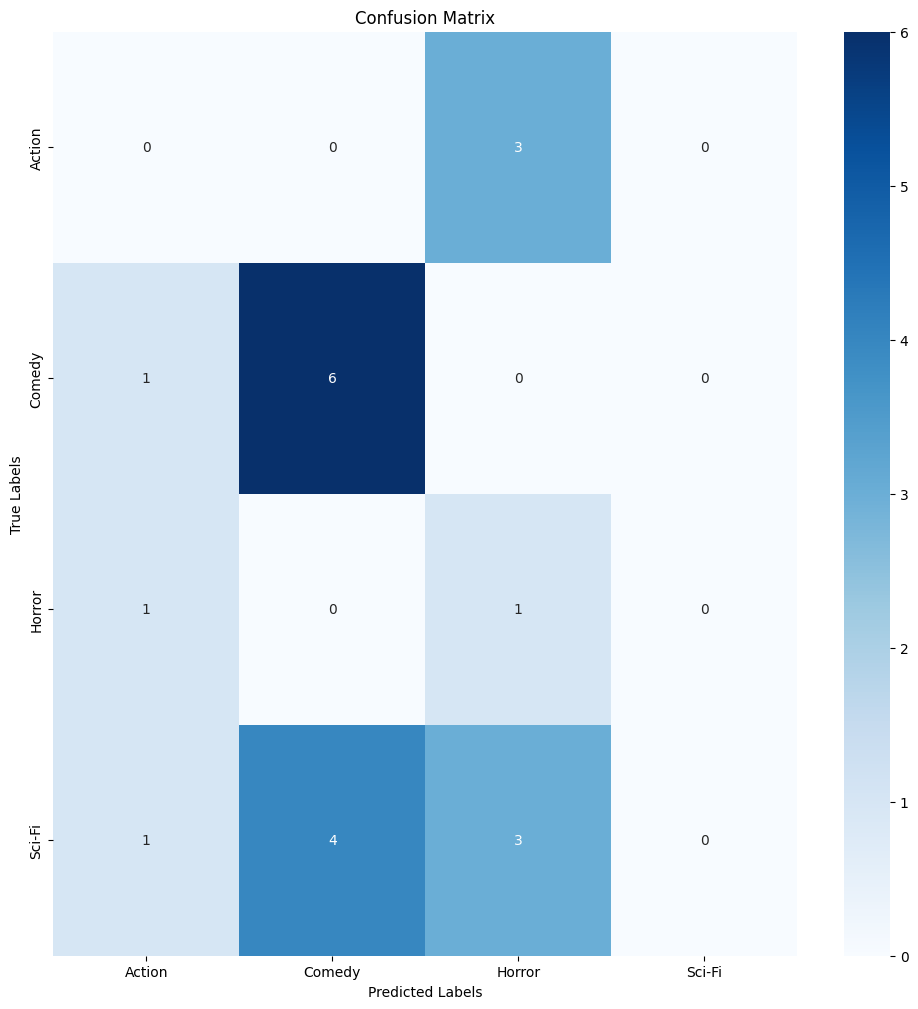

In [96]:
def plot_confusion_matrix(true_labels, predicted_labels, classes):
    cm = confusion_matrix(true_labels, predicted_labels, labels=classes)
    plt.figure(figsize=(12, 12))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    plt.show()

plot_confusion_matrix(true_labels, predicted_labels, encoder.classes_)


In [97]:

from sklearn.metrics import confusion_matrix
import pandas as pd

def print_confusion_matrix(true_labels, predicted_labels, classes):
    # Generate the confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels, labels=classes)

    # Create a DataFrame from the confusion matrix
    cm_df = pd.DataFrame(cm, index=classes, columns=classes)

    # Print the confusion matrix
    print("Confusion Matrix:")
    print(cm_df)

# Call the function with the true labels, predicted labels, and class names
print_confusion_matrix(true_labels, predicted_labels, encoder.classes_)


Confusion Matrix:
        Action  Comedy  Horror  Sci-Fi
Action       0       0       3       0
Comedy       1       6       0       0
Horror       1       0       1       0
Sci-Fi       1       4       3       0
